### Alright, Time for the Grand Finale.

We've gotten the models to learn the Simple Color Game in a 2x2 and a 3x3 grid, so now it's time to build up to the full 2-player Embodied Communication Game. The first step I'm going to take is to add a 5th action, "Stop" to the models, which they will have to take on the target square to recieve a reward.

I'll also be training the models here using a curriculum approach, where the reward function changes over time. I'll first allow them to recieve a reward whenever they touch the target square, then I'll give them an increased reward when they stop on the target square. Finally, I'll remove all other rewards.

In [1]:
#General Imports
import os
from copy import copy
import functools
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt

# Gymnasium Imports
import gymnasium as gym
from gymnasium.spaces import Discrete
from gymnasium.utils import seeding

#PettingZoo and Supersuit Imports
from pettingzoo import ParallelEnv
from pettingzoo.test import parallel_api_test
import supersuit as ss

# SB3 Imports
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor, SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy

from sb3_contrib import RecurrentPPO

#My Custom Functions
from functions import plot_results, plot_multi

In [40]:
#This will be the v1 of the game, with a stop function included.
class SimpleColorGame(gym.Env):
    # Initializes the Env, including observation space and action space. This one initializes the Observation space as a grid
    # of boxes with colors assigned to them, and the action space as the movement of the agent along the grid.
    def __init__(self, size=2, step_limit=200):
        # The size of one side of the square grid. It will be NxN squares in area, where N is self._size
        self._size = size
        self._num_colors = size**2

        # This is a time limit on the number of steps the agent is allowed to take in the game. This is necessary to
        # prevent the game from running forever if the agent's policy prevents it from moving or reaching the target.
        self._step_limit = step_limit
        # Integer to keep track of the number of steps taken in a particular iteration of the game
        self._step_count = 0

        #Boolean flag for STOP action. When the agent stops, this becomes true.
        self._stopped = False;

        # The agent location is stored inside of a local variable.
        self._agent_location = np.array([-1, -1], dtype=np.int32)

        # The colors of the boxes are also stored in a local variable. These colors are randomized on start-up. For this
        # version of the game, I will substitute integer values for colors.
        self._square_colors = np.arange(self._num_colors).reshape(size, size)

        # The target color will be a random number between 1 and 4. This number will be initialized during the reset() method.
        self._target_color = np.random.randint(0, self._num_colors)

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`-1}^2
        self.observation_space = gym.spaces.Dict(
            {
                "agent location": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "square colors": gym.spaces.Box(
                    0, self._num_colors - 1, shape=(size, size), dtype=int
                ),
                "target color": gym.spaces.Discrete(self._num_colors),
            }
        )

        # We have 5 actions, corresponding to "right", "up", "left", "down", and "stop"
        self.action_space = gym.spaces.Discrete(5)

        # Dictionary maps the abstract actions to the directions on the grid
        self._action_to_direction = {
            0: np.array([1, 0]),  # right
            1: np.array([0, 1]),  # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
            4: np.array([0,0]), #stop
        }

    # Helper method used to get the observation from the state, useful in reset and step methods. This version returns
    # the properties of agent location, square colors, and the target color.
    def _get_obs(self):
        return {
            "agent location": self._agent_location,
            "square colors": self._square_colors,
            "target color": self._target_color,
        }

    # Helper method used to get auxiliary information from the state. Currently returns nothing.
    def _get_info(self):
        info = {"info": None}
        return info

    # Helper method for calculating the reward from the state. This will be useful as I can override it in child classes.
    def _get_reward(self):
        reward = 0
        if (self._square_colors[tuple(self._agent_location)] == self._target_color):
            reward = 2 if (self._stopped == True) else 1
        return reward

    # Reset the environment to an initial configuration. The initial state may involve some randomness, so the seed argument
    # is used to guarantee an identical initial state whenever reset() is called with that seed. Options is a dict containing
    # any additional parameters we might want to specify during the reset.
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):

        # Firstly, we will call this method to seed self.np_random with the seed argument if given.
        super().reset(seed=seed)

        # Reset the step count to 0 for the new iteration of the game
        self._step_count = 0

        # Now randomly generate a starting location for the agent using self.np_random. We generate an array of size two
        # representing the agent's starting coordinates.
        self._agent_location = self.np_random.integers(0, self._size, size=2)

        # Generate a random permutation of the square colors, and reshape them into a sizeXsize grid.
        self._square_colors = self.np_random.permutation(self._num_colors).reshape(
            self._size, self._size
        )

        # Now we generate the target color, which is a random integer from 0 to self._num_colors inclusive.
        self._target_color = self.np_random.integers(0, self._num_colors)

        # Now we can return the observation and auxiliary info
        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    # Takes an action as input and updates the state of the Env according to that Action. Step then returns an observation
    # containing the new Env state, as well as some other additional variables and info.
    def step(self, action):
        # First, iterate the step count by one
        self._step_count += 1

        # Next, we convert our action to a direction.
        direction = self._action_to_direction[action]

        #Finally, we check for the STOP action.
        if action == 4:
            self._stopped = True

        # Then we add the direction coordinates to the agend coordinates to get the new agent location. We must clip the
        # agent location at the Box boundary, so the agent's coordinates are within 0 and self._size-1.
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self._size - 1
        )

        # Now we terminate the game and give the agent a reward if the square it's standing on is the target color.
        terminated = (
            self._square_colors[tuple(self._agent_location)] == self._target_color
        )

        # We also truncate the game if self._step_count > self._step_limit.
        truncated = self._step_count > self._step_limit

        # Reward is 1 if we are on the target color square, otherwise 0
        reward = self._get_reward()

        # Finally, use the helper functions to generate Obs and Info.
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info


# Now let's register this environment with a namespace and try calling gym.make on it later
gym.register(id="SimpleColorGame-v1", entry_point=SimpleColorGame)

C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment SimpleColorGame-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [12]:
#This will be the v1 of the game, with a stop function included.
class StopOnColorGame(gym.Env):
    # Initializes the Env, including observation space and action space. This one initializes the Observation space as a grid
    # of boxes with colors assigned to them, and the action space as the movement of the agent along the grid.
    def __init__(self, size=2, step_limit=200):
        self._size = size
        self._num_colors = size**2
        self._step_limit = step_limit
        self._step_count = 0
        self._stopped = False;

        self._agent_location = np.array([-1, -1], dtype=np.int32)
        self._square_colors = np.arange(self._num_colors).reshape(size, size)
        self._target_color = np.random.randint(0, self._num_colors)
        
        self.observation_space = gym.spaces.Dict(
            {
                "agent location": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "square colors": gym.spaces.Box(
                    0, self._num_colors - 1, shape=(size, size), dtype=int
                ),
                "target color": gym.spaces.Discrete(self._num_colors),
            }
        )
        self.action_space = gym.spaces.Discrete(5)

        # Dictionary maps the abstract actions to the directions on the grid
        self._action_to_direction = {
            0: np.array([1, 0]),  # right
            1: np.array([0, 1]),  # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
            4: np.array([0,0]), #stop
        }

    # Helper method used to get the observation from the state, useful in reset and step methods. This version returns
    # the properties of agent location, square colors, and the target color.
    def _get_obs(self):
        return {
            "agent location": self._agent_location,
            "square colors": self._square_colors,
            "target color": self._target_color,
        }

    # Helper method used to get auxiliary information from the state. Currently returns nothing.
    def _get_info(self):
        info = {"info": None}
        return info

    # Helper method for calculating the reward from the state. This will be useful as I can override it in child classes.
    def _get_reward(self):
        reward = 1 if (self._stopped == True and self._square_colors[tuple(self._agent_location)] == self._target_color) else 0
        return reward

    def _get_terminated(self):
        return self._stopped

    def _get_truncated(self):
        return self._step_count > self._step_limit;
    # Reset the environment to an initial configuration. The initial state may involve some randomness, so the seed argument
    # is used to guarantee an identical initial state whenever reset() is called with that seed. Options is a dict containing
    # any additional parameters we might want to specify during the reset.
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):

        # Firstly, we will call this method to seed self.np_random with the seed argument if given.
        super().reset(seed=seed)

        # Reset the step count to 0 for the new iteration of the game
        self._step_count = 0

        # Reset the _stopped flag
        self._stopped = False

        # Now randomly generate a starting location for the agent using self.np_random. We generate an array of size two
        # representing the agent's starting coordinates.
        self._agent_location = self.np_random.integers(0, self._size, size=2)

        # Generate a random permutation of the square colors, and reshape them into a sizeXsize grid.
        self._square_colors = self.np_random.permutation(self._num_colors).reshape(
            self._size, self._size
        )

        # Now we generate the target color, which is a random integer from 0 to self._num_colors inclusive.
        self._target_color = self.np_random.integers(0, self._num_colors)

        # Now we can return the observation and auxiliary info
        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    # Takes an action as input and updates the state of the Env according to that Action. Step then returns an observation
    # containing the new Env state, as well as some other additional variables and info.
    def step(self, action):
        # First, iterate the step count by one
        self._step_count += 1

        # Next, we convert our action to a direction.
        direction = self._action_to_direction[action]

        #Finally, we check for the STOP action.
        if action == 4:
            self._stopped = True

        # Then we add the direction coordinates to the agend coordinates to get the new agent location. We must clip the
        # agent location at the Box boundary, so the agent's coordinates are within 0 and self._size-1.
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self._size - 1
        )
        terminated = self._get_terminated()
        truncated = self._get_truncated()
        reward = self._get_reward()
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info


# Now let's register this environment with a namespace and try calling gym.make on it later
gym.register(id="StopOnColorGame-v0", entry_point=StopOnColorGame)

In [3]:
log_dir = "C:/Users/Owner/Documents/GitHub/independent-study-F24-learning-RL-with-gymnasium/log"
game = "SOCG-v0-s2"
mPPO_dir = f"{log_dir}/{game}/mPPO/"
mA2C_dir = f"{log_dir}/{game}/mA2C/"

In [20]:
# env_PPO = Monitor(gym.make("StopOnColorGame-v0"),mPPO_dir)
# env_A2C = Monitor(gym.make("StopOnColorGame-v0"),mA2C_dir)

mPPO = PPO("MultiInputPolicy",env_PPO,verbose=0)
mA2C = A2C("MultiInputPolicy",env_A2C,verbose=0)

mPPO.learn(100000, callback = EvalCallback(env, best_model_save_path=mPPO_dir, eval_freq=20000), progress_bar=True)
mA2C.learn(100000, callback = EvalCallback(env, best_model_save_path=mA2C_dir, eval_freq=20000), progress_bar=True)

Output()

C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: 
Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode 
lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor``
wrapper.
  warnings.warn(

Eval num_timesteps=20000, episode_reward=0.40 +/- 0.49

Episode length: 81.00 +/- 97.98

New best mean reward!

Eval num_timesteps=40000, episode_reward=0.20 +/- 0.40

Episode length: 41.20 +/- 79.90

Eval num_timesteps=60000, episode_reward=0.60 +/- 0.49

Episode length: 41.60 +/- 79.70

New best mean reward!

Eval num_timesteps=80000, episode_reward=0.80 +/- 0.40

Episode length: 1.80 +/- 0.40

New best mean reward!

Eval num_timesteps=100000, episode_reward=0.80 +/- 0.40

Episode length: 41.60 +/- 79.70

Output()

Eval num_timesteps=20000, episode_reward=0.20 +/- 0.40

Episode length: 1.00 +/- 0.00

New best mean reward!

Eval num_timesteps=40000, episode_reward=0.40 +/- 0.49

Episode length: 1.00 +/- 0.00

New best mean reward!

Eval num_timesteps=60000, episode_reward=0.20 +/- 0.40

Episode length: 1.00 +/- 0.00

Eval num_timesteps=80000, episode_reward=0.20 +/- 0.40

Episode length: 1.00 +/- 0.00

Eval num_timesteps=100000, episode_reward=0.00 +/- 0.00

Episode length: 1.00 +/- 0.00

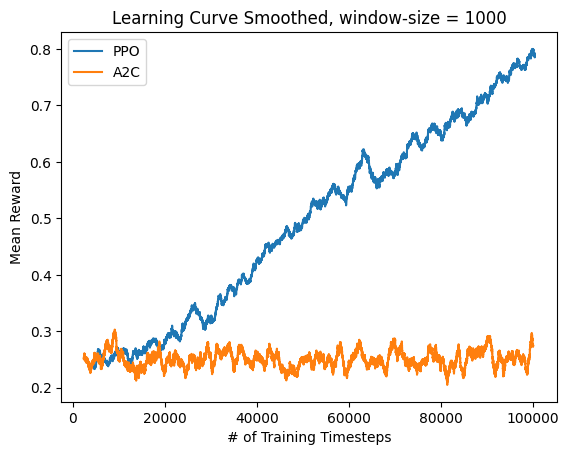

In [4]:
plot_multi([mPPO_dir,mA2C_dir],["PPO","A2C"],window=1000)

### Evidently, PPO is able to solve the 2x2 relatively quickly

even when an additional "Stopping" step is required. Now we just have to design the 2-player version of the game and start logging PPO's effectiveness in that version.

### ...

Alright, I've now completed a side-quest to learn Gymnasium's **PettingZoo** API, which allows me to create and run multi-agent *Envs*. I don't yet know how to run SB3 models on *PettingZoo* Envs, but I'll learn that shortly. Now that I have a handle on how to create them, I think it's time I designed the full-fledged **Embodied Communication Game** *v1.0*.

## Embodied Communication Game 
#### (multi-Agent Environment using Gymnasium's *PettingZoo*)

I'm going to be using PettingZoo's *ParallelEnv* class to create this Env as a simultaneous-action Env supporting two agents. The class will need to support two agents, and have the following characteristics:
- 2 separate 2x2 Gridworld Envs, one containing each agent's avatar.
- Action space of 5 possible actions for each agent, corresponding to movement *up*, *right*, *down*, *left*, and *commit*, which causes the agent to commit to a particular square.
- 7 unique colors, of which each grid contains 4 distinct colors. This ensures that at a minimum, 1 color is shared between grids, which ensures the *possibility* of a 100% success rate.
- Separate observations for each agent, such that each agent only knows the colors of the squares on their own grid. All other observations about the *Env state* are shared.
- A reward structure which rewards the agents for committing to a square of the same color as the other agent.
- *Env* logic to update the Env's state according to the Agents' actions.

One aspect of the **ECG** which I can't capture using this *Env*, but which is likely necessary for the 100% success rate seen in human play, is memory. For the agents to successfully interpret their compatriots' behavior as communication, they must be able to not only know where they are, but remember where they were. For them to learn a pattern of communication, their short-term memory must be long enough for them to recall the entire patter of movement. I'm not sure exactly how to implement that yet, but that will be the first TODO once I have the base ECG up and running.

In [6]:
class EmbodiedCommunicationGame(ParallelEnv):
    """
    My first naive implementation of the ECG in Gymnasium's PettingZoo.
    """
    metadata = { "render_modes": [],
        "name":"EmbodiedCommunicationGame-v0"}
    
    def __init__(self, step_limit = 100):
        """
        Variables to instantiate:
        -2 Grids 
        -2 Agent locations
        -Color List
        -Step Count
        -Step Limit
        -Possible Agents (agents)?
        We will not initialize the agent locations or grid color patterns here, that will occur in self.reset().
        We instantiate the variables here to keep better track of them.
        """

        #public variables
        self.step_limit = step_limit
        self.possible_agents = ["agent1", "agent2"]
        self.render_mode = None
        self.spec = None
        
        #private variables
        self._step_count = 0

        #Grids, agent coords, and agents committed. To make step() easier, I'm going to put each of these into it's own
        # dict, with keys corresponding to agent names.
        self._color_grids = {a : np.zeros((2,2)) for a in self.possible_agents}

        self._agent_coords = {a : np.array([-1,-1], dtype=np.int32) for a in self.possible_agents}

        #Track whether agents are committed.
        self._agents_committed = {a : False for a in self.possible_agents}
        
        #Dictionary to map action space to a direction on the Gridworld.
        self._action_to_direction = {
            0: np.array([0,-1]), #Down
            1: np.array([1,0]), #Right
            2: np.array([0,1]), #Up
            3: np.array([-1,0]), #Left
            4: np.array([0,0]), #Commit, for redundancy.
        }
        
        #Color list
        self._colors = np.arange(8)

        self._observation_spaces = { a : {
            "myCoords" : self._agent_coords[a],
            "allCoords" : [self._agent_coords[a] for a in self.possible_agents],
            "myColors" : self._color_grids[a],
        } for a in self.possible_agents }
            
        
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        """
        initialize the Env for play.
        Variables to initialize:
        -Agent locations
        -Color arrangements for each 2x2 grid
        -step-count
        -Agent committed flag
        """
        #call super().reset() with seed to set self.np_random with seed.
        self._seed(seed)

        #Reset flags
        self._step_count = 0

        #Instantiate self.agents to be a copy (by value) of self.possible_agents.
        self.agents = copy(self.possible_agents)

        #Iteratively generate agent data, including grid color, agent location, and agent committed.
        for a in self.agents:
            self._color_grids[a] = self.np_random.choice(self._colors, size = (2,2), replace = False)
            self._agent_coords[a] = self.np_random.integers(0,2, size=(2,))
            self._agents_committed[a] = False
        
        #now to return obs and infos
        obs = self._get_obs()
        infos = self._get_infos()
        # print("obs: ",obs,"infos: ",infos, sep="\n\n")
        
        return obs, infos

    def step(self, actions):
        """
        update the Env according to the actions of each agent.
        returns:
        obs{}, rewards{}, terminateds{}, truncateds{}, infos{}
        """
        
        for (agent, action) in actions.items():
            
            #update the agent committed status first.
            if action == 4:
                self._agents_committed[agent] = True
                
            #Update agent's coordinates only if agent not committed. Checking action != 4 for redundancy.
            if (self._agents_committed[agent] == False and action != 4):
                direction = self._action_to_direction[action]
                self._agent_coords[agent] = np.clip(self._agent_coords[agent] + direction, 0, 1)

        self._step_count += 1
        
        #Now calculate the return values.
        obs = self._get_obs()
        rewards, terminateds, truncateds = self._get_rewards_terminateds_truncateds()
        infos = self._get_infos()

        if all(terminateds.values()) or all(truncateds.values()):
            self.agents = []

        return obs, rewards, terminateds, truncateds, infos

    def _seed(self, seed = None):
        self.np_random, seed = seeding.np_random(seed)

    def _get_obs(self):
        #I tried getting fancy and generating this with a loop, but it was causing problems, so for now I'm just going
        # to make it by hand.
        a1 = self.agents[0]
        a2 = self.agents[1]
        obs = {
            a1 : {
                "myCoords" : self._agent_coords[a1],
                "theirCoords" : self._agent_coords[a2],
                "myColors" : self._color_grids[a1],
            },
            a2 : {
                "myCoords" : self._agent_coords[a2],
                "theirCoords" : self._agent_coords[a1],
                "myColors" : self._color_grids[a2],
            },
        }
                     
        return obs

    def _get_rewards_terminateds_truncateds(self):
        """
        this function will return the rewards, terminateds, and truncateds state.
        There is specific logic relating rewards to truncation and termination.
        """   
        #we're basically building up a long boolean check to see if the agents have both committed to squares of the
        # same color. For that reason, I'm going to shorten some of these variable names to make the boolean statement
        # more readable.
        a1 = self.agents[0]
        a2 = self.agents[1]
        grid1 = self._color_grids[a1]
        grid2 = self._color_grids[a2]
        a1_coords = self._agent_coords[a1]
        a2_coords = self._agent_coords[a2]

        #Common/base case for terminated/reward is Terminated = False and Reward = 0. I want to also punish agents for
        # not committing to speed up the process of committing at some point.
        rewards = {a: (-1 if self._step_count > self.step_limit else 0) for a in self.agents}
        terminateds = {a: False for a in self.agents}
        truncateds = {a : self._step_count > self.step_limit for a in self.agents}

        #If both of the agents have committed, Terminated = True.
        if (self._agents_committed[a1] == True and self._agents_committed[a2] == True):
            terminateds = {a : True for a in self.agents}
            
            #If the color of a1's square matches the color of a2's square, reward = 1. Noteably, we only reward
            # the agents for having matching square colors if both agents have chosen to commit to their squares.
            if (grid1[tuple(a1_coords)] == grid2[tuple(a2_coords)]):
                rewards = {a : 1 for a in self.agents}
        
        return rewards, terminateds, truncateds

    #TODO: Learn more about what I can use info for. this might be a way to give the agents some form of memory.
    def _get_infos(self):
        return {a : {} for a in self.agents}

    #Farama recommends using memo-ized functions for returning action_space and observation_space rather than public
    # or private class variables.
    @functools.lru_cache(maxsize=None)
    def observation_space(self,agent):
        return gym.spaces.Dict({
            "myCoords": gym.spaces.Box(0,2, shape = (2,), dtype=int),
            "theirCoords": gym.spaces.Box(0,2, shape = (2,), dtype=int),
            "myColors": gym.spaces.Box(0,8, shape = (2,2), dtype=int),
        })

    @functools.lru_cache(maxsize=None)
    def action_space(self,agent):
        return Discrete(5)

### We did it!!! 

We should now have a fully functional version of the **Embodied Communication Game** for use in Gymnasium! This is what I've been working towards for some time. The next step is now to figure out a way to throw the powerful **SB3** RL models at it (looking at you **PPO**.)

I'm first going to find a way to train an SB3 PPO model on the tutorial *ParallelEnv*, **Guard and Prisoner**. Then I'll come back here and hook up this *Env* to the SB3 models as best I can. I don't expect optimal performance from just throwing the models at it, and realistically I anticipate that I'll have to modify this game in some capacity to add some form of *memory* which the models can interpret...
    
#### But ...
this is what I've been building up to for the past month! I finally built the full game in Gymnasium, and I'm proud I reached this milestone.

### Time to convert it into an SB3 VecEnv and train our models on it!

In [2]:
log_dir = "C:/Users/Owner/Documents/GitHub/independent-study-F24-learning-RL-with-gymnasium/log"
game = "ECG-v0"
mPPO_dir = f"{log_dir}/{game}/mPPO/"
os.makedirs(mPPO_dir, exist_ok=True)

In [4]:
env = EmbodiedCommunicationGame()
parallel_api_test(env, num_cycles=1000)

#One weird error I encountered was that it told me
env = ss.pettingzoo_env_to_vec_env_v1(env)
env = ss.concat_vec_envs_v1(env, 10, base_class = "stable_baselines3")
#Wrapping the Env in the SB3 Monitor() Wrapper requires the Env to have a .spec attribute, which the SuperSuit conversion
# never added. This attribute can be None. I'm setting it manually so I can use SB3's Monitor Wrapper.
# env.spec = None
env = VecMonitor(env, mPPO_dir)
mPPO = PPO(
    "MultiInputPolicy",
    env,
    verbose = 0
)

# #As celebration for finally fucking making the EMBODIED COMMUNICATION GAME, I'm throwing all the might of the mighty PPO algorithm at it!
# #We'll find out what PPO's optimal performance in this game is after 1000000 training timesteps on a 2-VecEnv!
mPPO.learn(total_timesteps=100000, progress_bar=True)
mPPO.save(mPPO_dir+"/Te6")
mPPO.learn(1000000, progress_bar=True)
mPPO.save(mPPO_dir+"/Te7")
mPPO.learn(4000000, progress_bar=True)
mPPO.save(mPPO_dir+"/Te7.5")
mPPO.learn(5000000, progress_bar=True)
mPPO.save(mPPO_dir+"/Te8")

Passed Parallel API test


Output()

Output()

Output()

Output()

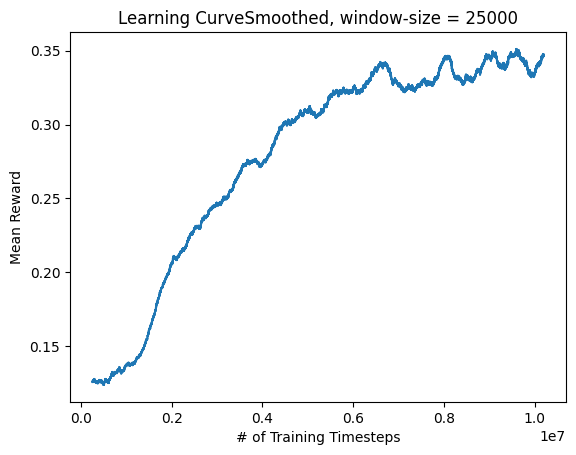

In [15]:
plot_results(mPPO_dir, window = 25000, gaussian = True)

In [3]:
log_dir = "C:/Users/Owner/Documents/GitHub/independent-study-F24-learning-RL-with-gymnasium/log"
game = "ECG-v0"
mR_PPO_dir = f"{log_dir}/{game}/mRecurrentPPO/"
os.makedirs(mPPO_dir, exist_ok=True)

In [7]:
env = EmbodiedCommunicationGame()
parallel_api_test(env, num_cycles=1000)

#One weird error I encountered was that it told me
env = ss.pettingzoo_env_to_vec_env_v1(env)
env = ss.concat_vec_envs_v1(env, 10, base_class = "stable_baselines3")
#Wrapping the Env in the SB3 Monitor() Wrapper requires the Env to have a .spec attribute, which the SuperSuit conversion
# never added. This attribute can be None. I'm setting it manually so I can use SB3's Monitor Wrapper.
# env.spec = None
env = VecMonitor(env, mPPO_dir)
mPPO = RecurrentPPO(
    "MultiInputLstmPolicy",
    env,
    verbose = 0
)

# #As celebration for finally fucking making the EMBODIED COMMUNICATION GAME, I'm throwing all the might of the mighty PPO algorithm at it!
# #We'll find out what PPO's optimal performance in this game is after 1000000 training timesteps on a 2-VecEnv!
mPPO.learn(total_timesteps=100000, progress_bar=True)
mPPO.save(mPPO_dir+"/Te6")
mPPO.learn(1000000, progress_bar=True)
mPPO.save(mPPO_dir+"/Te7")
mPPO.learn(4000000, progress_bar=True)
mPPO.save(mPPO_dir+"/Te7.5")
mPPO.learn(5000000, progress_bar=True)
mPPO.save(mPPO_dir+"/Te8")

Passed Parallel API test


Output()

Output()

Output()

Output()

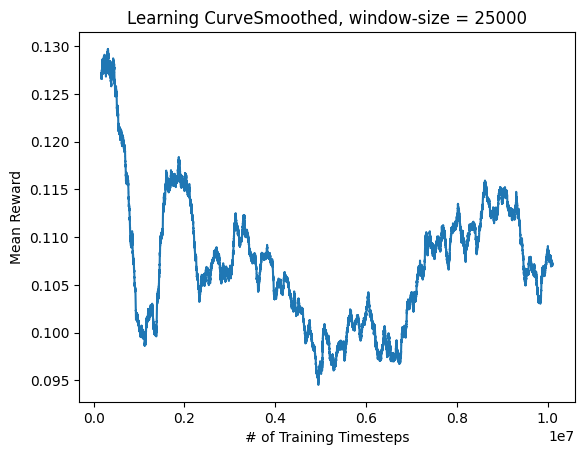

In [4]:
plot_results(mPPO_dir, window = 25000, gaussian = True)

Sadly, the Recurrent PPO model didn't learn any communication strategy..... It was a long-shot, and unfortunately it took ages to train and nearly roasted my laptop during training. This is unfortunate, but the next step would be to add some information to the environment itself which the PPO model could potentially use as input.

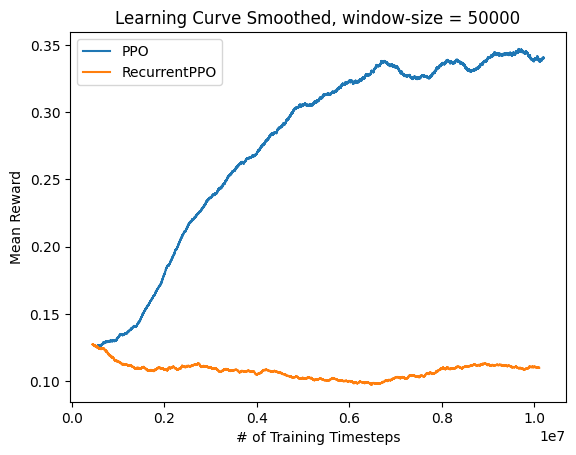

In [4]:
plot_multi([mPPO_dir,mR_PPO_dir],["PPO","RecurrentPPO"], window=50000, gaussian = True)